In [71]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import glob
import itertools

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


### Setup path for result folder and glob all of the result file paths into list

In [2]:
result_root = paths.tmp_dir + '/DIF/results/new'
result_files = glob.glob("%s/full_results_[0-9].csv" % (result_root))
result_files

['/Users/trafferty/tmp/DIF/results/new/full_results_1.csv',
 '/Users/trafferty/tmp/DIF/results/new/full_results_2.csv',
 '/Users/trafferty/tmp/DIF/results/new/full_results_3.csv']

### Combine all of the result files into one

In [3]:
df_list = []
for i, f in enumerate(result_files):
    df_sub = pd.read_csv(f)
    df_sub.insert(0, 'Experiment Num', i+1)
    print(f"...read in {len(df_sub)} from {f}")
    df_list.append(df_sub)
df = pd.concat(df_list).reset_index(drop=True)
print(f"Total datapoints read: {len(df)}")

...read in 1075 from /Users/trafferty/tmp/DIF/results/new/full_results_1.csv
...read in 715 from /Users/trafferty/tmp/DIF/results/new/full_results_2.csv
...read in 180 from /Users/trafferty/tmp/DIF/results/new/full_results_3.csv
Total datapoints read: 1970


#### Save combined results just for the hell of it...

In [4]:
df.to_csv("%s/full_results_combined.csv" % (result_root))

#### Fix header fields, which have leading space in it

In [5]:
df.columns = [field.strip() for field in df.columns]
df.columns

Index(['Experiment Num', 'LoopID', 'ImageFile', 'Pattern', 'Waveform',
       'Voltage', 'Clock', 'PD_delay_us', 'Row', 'Nozzle', 'NOI', 'Phase',
       'Column', 'Primary', 'Velocity', 'Vol_top', 'Vol_bot'],
      dtype='object')

#### ...and also the columns with string data:

In [6]:
for col_name in df.columns:
    if df[col_name].dtype == 'O':
        print(f"Stripping column {col_name}, which is dtype 'O'")
        df[col_name] = df[col_name].str.strip()

Stripping column ImageFile, which is dtype 'O'
Stripping column Pattern, which is dtype 'O'
Stripping column Waveform, which is dtype 'O'
Stripping column NOI, which is dtype 'O'
Stripping column Phase, which is dtype 'O'
Stripping column Primary, which is dtype 'O'
Stripping column Velocity, which is dtype 'O'
Stripping column Vol_top, which is dtype 'O'
Stripping column Vol_bot, which is dtype 'O'


#### Now fix the Velocity, Vol_top and Vol_bot series (convert to float, replace 'n/a' with NaN)

In [8]:
for field in ['Velocity', 'Vol_top', 'Vol_bot']:
    df[field] = pd.to_numeric(df[field], errors='coerce')

#### Create new column with mean volume

In [9]:
df['Vol_mean'] = (df['Vol_top'] + df['Vol_bot']) / 2.0

#### Define some functions to use for classifying results based on volume and velocity ranges

In [18]:
vel_desired_range = (4.0, 5.0)
vol_desired_range = (0.8, 1.0)

def calc_class_str(vol, vel):
    vol_in_range = True if vol >= vol_desired_range[0] and vol <= vol_desired_range[1] else False
    vel_in_range = True if vel >= vel_desired_range[0] and vel <= vel_desired_range[1] else False
    if vol_in_range and vel_in_range:
        return 'vel_vol_in_range'
    elif vol_in_range:
        return 'vol_in_range'
    elif vel_in_range:
        return 'vel_in_range'
    else:
        return 'out_of_range'
        
def calc_class(vol, vel):
    vol_in_range = True if vol >= vol_desired_range[0] and vol <= vol_desired_range[1] else False
    vel_in_range = True if vel >= vel_desired_range[0] and vel <= vel_desired_range[1] else False
    if vol_in_range and vel_in_range:
        return 4
    elif vol_in_range:
        return 2
    elif vel_in_range:
        return 1
    else:
        return 0
        

#### Now, execute these functions for all rows in dataframe, creating new columns for class:
    vel_vol_in_range (4): Both velocity and volume in desired range
    vol_in_range (2): Volume only in desired range
    vel_in_range (1): Velocity only in desired range
    out_of_range (0): Neither velocity or volume in desired range
    

In [19]:
df['class'] = np.vectorize(calc_class)(df['Vol_mean'], df['Velocity'])
df['class_label'] = np.vectorize(calc_class_str)(df['Vol_mean'], df['Velocity'])

In [22]:
df.head()

,Experiment Num,LoopID,ImageFile,Pattern,Waveform,Voltage,Clock,PD_delay_us,Row,Nozzle,...,Column,Primary,Velocity,Vol_top,Vol_bot,Vol_mean,category,category_label,class,class_label
0,1,1,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/g4x8_A204_26x33.drp,dis_waveform_time2.csv,0,0,159.0,1,28,...,4,True,NaN,NaN,NaN,NaN,0,out_of_range,0,out_of_range
1,1,1,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/g4x8_A204_26x33.drp,dis_waveform_time2.csv,0,0,159.0,1,29,...,3,True,4.935,0.975,1.000,0.9875,4,vel_vol_in_range,4,vel_vol_in_range
2,1,1,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/g4x8_A204_26x33.drp,dis_waveform_time2.csv,0,0,159.0,1,30,...,2,True,4.889,0.852,0.905,0.8785,4,vel_vol_in_range,4,vel_vol_in_range
3,1,1,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/g4x8_A204_26x33.drp,dis_waveform_time2.csv,0,0,159.0,1,31,...,1,True,4.558,0.933,0.952,0.9425,4,vel_vol_in_range,4,vel_vol_in_range
4,1,1,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/g4x8_A204_26x33.drp,dis_waveform_time2.csv,0,0,159.0,1,32,...,0,True,4.865,1.013,1.066,1.0395,1,vel_in_range,1,vel_in_range


#### Experimented a bit with using a dummies truth table, but didn't end up using it

In [89]:
features = ['class', 'class_label']
df_dummies = pd.get_dummies(df[features])
df_dummies.head()

,class,class_label_out_of_range,class_label_vel_in_range,class_label_vel_vol_in_range,class_label_vol_in_range
0,0,1,0,0,0
1,4,0,0,1,0
2,4,0,0,1,0
3,4,0,0,1,0
4,1,0,1,0,0


#### Plot data and colorize based on class column

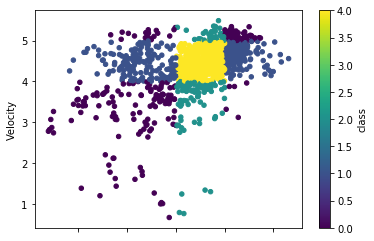

In [24]:
df.plot(x='Vol_mean', y='Velocity', kind = 'scatter', c ='class', colormap='viridis')

In [25]:
#### Create dataframe with just the rows with velocity and volumes in desired ranges

In [29]:
df_good = df.loc[df['class'] == 4, :]
print(f"Number of rows with volume and velocity in desired ranges: {len(df_good)}")

Number of rows with volume and velocity in desired ranges: 678


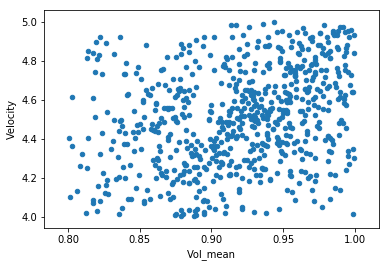

In [30]:
df_good.plot(x='Vol_mean', y='Velocity', kind = 'scatter')

#### Save these in their own file...

In [31]:
df_good.to_csv("%s/full_results_within_range.csv" % (result_root))

#### Categorize some columns as certain types:
    disp_settings: dispenser settings
    nozzle_settings: nozzle settings
    image_settings: image settings

In [32]:
disp_settings = ['Pattern', 'Waveform', 'Voltage', 'Clock', 'PD_delay_us']
nozzle_settings = ['Row', 'Nozzle', 'Phase']
image_settings = ['NOI', 'Column', 'Primary']

#### Now, for each category, get list of unique values for that column, put in dict for later

In [99]:
disp_unique = {}
for disp_setting in disp_settings:
    disp_unique[disp_setting] = list(df_good[disp_setting].unique())
print(f"Unique dispenser settings:\n{disp_unique}")

nozzle_unique = {}
for nozzle_setting in nozzle_settings:
    nozzle_unique[nozzle_setting] = list(df_good[nozzle_setting].unique())
print(f"\nUnique nozzle settings:\n{nozzle_unique}")

image_unique = {}
for image_setting in image_settings:
    image_unique[image_setting] = list(df_good[image_setting].unique())
print(f"\nUnique image settings:\n{image_unique}")


Unique dispenser settings:
{'Pattern': ['bmp/g4x8_A204_26x33.drp', 'bmp/g2x8_A204_26x33.drp', 'bmp/g6x8_A204_26x33.drp', 'bmp/g4x16_A204_26x33.drp', 'bmp/g4x4_AB_A204_26x33.drp', 'bmp/g4x2_all_A204_26x33.drp', 'bmp/kk_RowA_8x8s0.drp', 'bmp/kk_8x2s0.drp', 'bmp/kk_8x6s0.drp', 'bmp/5X12s1.drp', 'bmp/kk_10X12s0.drp'], 'Waveform': ['dis_waveform_time2.csv'], 'Voltage': [0], 'Clock': [0], 'PD_delay_us': [159.0, 185.0, 287.0]}

Unique nozzle settings:
{'Row': [1], 'Nozzle': [29, 30, 31, 36, 37, 39, 41, 42, 45, 46, 48, 49, 51, 53, 55, 56, 58, 60, 61, 62, 67, 68, 69, 72, 74, 76, 79, 82, 84, 85, 86, 88, 90, 91, 94, 95, 96, 101, 102, 105, 106, 107, 108, 111, 112, 114, 115, 116, 118, 119, 123, 124, 129, 130, 131, 132, 133, 134, 135, 140, 141, 142, 144, 149, 150, 151, 153, 155, 159, 160, 161, 165, 169, 170, 171, 173, 176, 180, 183, 190, 192, 193, 194, 195, 196, 199, 201, 35, 97, 137, 164, 177, 202, 43, 50, 64, 104, 148, 163, 167, 198, 44, 136, 154, 184, 63, 187, 125, 182, 188, 200, 38], 'Phase': ['

#### For the unique dispense setting values, create a list of all permutations of these settings

In [36]:
permuts = list(itertools.product(disp_unique['Pattern'], disp_unique['Waveform'], disp_unique['Voltage'], disp_unique['Clock'], disp_unique['PD_delay_us']))
print(f"Permutation count: {len(permuts)}")

Permutation count: 33


In [70]:
# sandbox
pat, wf, volt, clock, pd_delay = permuts[0]
print(f"{pat}, {wf}, {volt}, {clock}, {pd_delay}")
len(df['Nozzle'].unique())

bmp/g4x8_A204_26x33.drp, dis_waveform_time2.csv, 0, 0, 159.0


175

In [38]:
# sandbox
#df_sub = df.loc[(df['Pattern'] == pat) & (df['Waveform'] == wf) & (df['Voltage'] == v) & (df['Clock'] == c) & (df['PD_delay_us'] == pd_delay) ]
#df_sub = df.loc[(df['Pattern'] == pat)  ]
#df_sub = df.loc[(df['Pattern'] == pat) & (df['Waveform'] == wf) ]
#df_sub = df.loc[(df['Pattern'] == pat) & (df['Waveform'] == wf) & (df['PD_delay_us'] == pd_delay) ]
df_sub = df_good.loc[(df['Pattern'] == pat) & (df['PD_delay_us'] == pd_delay) ]
len(df_sub)
np.var(df_sub['Vol_mean'].values)

0.0025101257229683364

#### For each permutation of dispense settings:
- calculate the variance of the volume and velocity for all nozzles using those settings.
- calculate the 'score' for the settings: vel variance multiplied by volume variance (lowest score indicates the dispense settings with the lowest overall variance, therefore the best)
- append (key, score) tuple to list of scores

##### ...then sort the list of scores by lowest first

In [77]:
vel_vol_scores = []
for i, permut in enumerate(permuts):
    pat, wf, volt, clock, pd_delay = permut
    key = f"{pat}:{wf}:{volt}:{clock}:{pd_delay}"
    df_sub = df_good.loc[(df_good['Pattern'] == pat) & (df_good['Waveform'] == wf) & (df_good['Voltage'] == volt) & (df_good['Clock'] == clock) & (df_good['PD_delay_us'] == pd_delay) ]
    if len(df_sub):
        vol_var = np.var(df_sub['Vol_mean'].values)
        vel_var = np.var(df_sub['Velocity'].values)
        score = vol_var * vel_var
        vel_vol_scores.append( (key, score) )
        print(f"{key}: vol variance: {vol_var:.6f} vel variance: {vel_var:.6f}, score: {score:.6f}")   
vel_vol_scores_sorted = sorted(vel_vol_scores, key=lambda tup: tup[1])
vel_vol_scores_sorted

bmp/g4x8_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0: vol variance: 0.002510 vel variance: 0.061715, score: 0.000155
bmp/g2x8_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0: vol variance: 0.002230 vel variance: 0.062140, score: 0.000139
bmp/g6x8_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0: vol variance: 0.002620 vel variance: 0.058767, score: 0.000154
bmp/g4x16_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0: vol variance: 0.002347 vel variance: 0.049570, score: 0.000116
bmp/g4x4_AB_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0: vol variance: 0.002187 vel variance: 0.055691, score: 0.000122
bmp/g4x2_all_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0: vol variance: 0.002233 vel variance: 0.060457, score: 0.000135
bmp/kk_RowA_8x8s0.drp:dis_waveform_time2.csv:0:0:185.0: vol variance: 0.002316 vel variance: 0.053748, score: 0.000124
bmp/kk_8x2s0.drp:dis_waveform_time2.csv:0:0:185.0: vol variance: 0.002028 vel variance: 0.049780, score: 0.000101
bmp/kk_8x6s0.drp:dis_waveform_tim

[('bmp/kk_8x6s0.drp:dis_waveform_time2.csv:0:0:185.0', 7.659612859297966e-05),
 ('bmp/kk_8x2s0.drp:dis_waveform_time2.csv:0:0:185.0', 0.00010096204825481116),
 ('bmp/g4x16_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0',
  0.00011633470820891382),
 ('bmp/g4x4_AB_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0',
  0.00012180787380276934),
 ('bmp/kk_RowA_8x8s0.drp:dis_waveform_time2.csv:0:0:185.0',
  0.0001244828144510174),
 ('bmp/g4x2_all_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0',
  0.00013498072701837469),
 ('bmp/g2x8_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0',
  0.00013859848048149712),
 ('bmp/g6x8_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0',
  0.00015396203809217),
 ('bmp/g4x8_A204_26x33.drp:dis_waveform_time2.csv:0:0:159.0',
  0.00015491219811388643),
 ('bmp/kk_10X12s0.drp:dis_waveform_time2.csv:0:0:287.0',
  0.00017415048029146868),
 ('bmp/5X12s1.drp:dis_waveform_time2.csv:0:0:185.0', 0.0002112945117606721)]

In [78]:
# sandbox...
key = vel_vol_scores_sorted[0][0]
pat, wf, volt, clock, pd_delay = key.split(":")
print(f"{pat}, {wf}, {volt}, {clock}, {pd_delay}")
df_good.loc[(df_good['Pattern'] == pat) & (df_good['Waveform'] == wf) & (df_good['Voltage'] == int(volt)) & (df_good['Clock'] == int(clock)) & (df_good['PD_delay_us'] == float(pd_delay)) ]

bmp/kk_8x6s0.drp, dis_waveform_time2.csv, 0, 0, 185.0


,Experiment Num,LoopID,ImageFile,Pattern,Waveform,Voltage,Clock,PD_delay_us,Row,Nozzle,...,Column,Primary,Velocity,Vol_top,Vol_bot,Vol_mean,category,category_label,class,class_label
1433,2,72,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,36,...,1,True,4.400,0.895,0.903,0.8990,4,vel_vol_in_range,4,vel_vol_in_range
1436,2,73,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,39,...,3,True,4.853,0.986,0.979,0.9825,4,vel_vol_in_range,4,vel_vol_in_range
1439,2,73,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,42,...,0,True,4.395,0.969,0.999,0.9840,4,vel_vol_in_range,4,vel_vol_in_range
1442,2,74,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,45,...,2,True,4.905,0.918,0.947,0.9325,4,vel_vol_in_range,4,vel_vol_in_range
1448,2,75,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,51,...,1,True,4.920,0.977,0.961,0.9690,4,vel_vol_in_range,4,vel_vol_in_range
1457,2,77,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,60,...,2,True,4.744,0.919,0.953,0.9360,4,vel_vol_in_range,4,vel_vol_in_range
1466,2,79,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,69,...,3,True,4.765,0.981,0.994,0.9875,4,vel_vol_in_range,4,vel_vol_in_range
1469,2,79,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,72,...,0,True,4.461,0.953,0.957,0.9550,4,vel_vol_in_range,4,vel_vol_in_range
1493,2,84,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,96,...,1,True,4.934,0.896,0.948,0.9220,4,vel_vol_in_range,4,vel_vol_in_range
1497,2,85,/media/DIF_DATA/images/2019-04-12_14.22.53/Dis...,bmp/kk_8x6s0.drp,dis_waveform_time2.csv,0,0,185.0,1,102,...,0,True,4.648,0.940,0.994,0.9670,4,vel_vol_in_range,4,vel_vol_in_range


#### For each set in the sorted list of best scores:
- extract the disp settings from the hash (key)
- use locate to get rows with the dispence settings from the hash
- append this dataframe to list

##### ...then use list to create new dataframe with the best results 


In [80]:
best = []
for key, score in vel_vol_scores_sorted:
    pat, wf, volt, clock, pd_delay = key.split(":")
    df_sub = df_good.loc[(df_good['Pattern'] == pat) & (df_good['Waveform'] == wf) & (df_good['Voltage'] == int(volt)) & (df_good['Clock'] == int(clock)) & (df_good['PD_delay_us'] == float(pd_delay)) ]
    print(f"Adding {len(df_sub)} rows with disp settings: {pat}, {wf}, {volt}, {clock}, {pd_delay} -> score: {score}")
    best.append(df_sub)
df_best = pd.concat(best).reset_index(drop=True)

Adding 23 rows with disp settings: bmp/kk_8x6s0.drp, dis_waveform_time2.csv, 0, 0, 185.0 -> score: 7.659612859297966e-05
Adding 75 rows with disp settings: bmp/kk_8x2s0.drp, dis_waveform_time2.csv, 0, 0, 185.0 -> score: 0.00010096204825481116
Adding 48 rows with disp settings: bmp/g4x16_A204_26x33.drp, dis_waveform_time2.csv, 0, 0, 159.0 -> score: 0.00011633470820891382
Adding 83 rows with disp settings: bmp/g4x4_AB_A204_26x33.drp, dis_waveform_time2.csv, 0, 0, 159.0 -> score: 0.00012180787380276934
Adding 87 rows with disp settings: bmp/kk_RowA_8x8s0.drp, dis_waveform_time2.csv, 0, 0, 185.0 -> score: 0.0001244828144510174
Adding 81 rows with disp settings: bmp/g4x2_all_A204_26x33.drp, dis_waveform_time2.csv, 0, 0, 159.0 -> score: 0.00013498072701837469
Adding 44 rows with disp settings: bmp/g2x8_A204_26x33.drp, dis_waveform_time2.csv, 0, 0, 159.0 -> score: 0.00013859848048149712
Adding 94 rows with disp settings: bmp/g6x8_A204_26x33.drp, dis_waveform_time2.csv, 0, 0, 159.0 -> score: 0

#### Hmmm.  Interesting that there are not many rows added for some of the disp settings.  Lets go back to original data set and see how many of these settings were out of range.

In [87]:
permuts_disp_settings = list(itertools.product(disp_unique['Pattern'], disp_unique['Waveform'], disp_unique['Voltage'], disp_unique['Clock']))
print(f"Permutation count: {len(permuts_disp_settings)}\n")

for i, permut in enumerate(permuts_disp_settings):
    pat, wf, volt, clock = permut
    key = f"{pat}:{wf}:{volt}:{clock}"
    df_sub = df.loc[(df['Pattern'] == pat) & (df['Waveform'] == wf) & (df['Voltage'] == int(volt)) & (df['Clock'] == int(clock)) ]
    print(f"For {key}, total rows: {len(df_sub)}:")
    class_labels = ['vel_vol_in_range', 'vol_in_range', 'vel_in_range', 'out_of_range']
    for class_label in class_labels:
        count = len(df_sub.loc[df_sub['class_label'] == class_label, :])
        print(f" ...{count} are {class_label}")

    print("------------------------------------")
              


Permutation count: 11

For bmp/g4x8_A204_26x33.drp:dis_waveform_time2.csv:0:0, total rows: 200:
 ...101 are vel_vol_in_range
 ...10 are vol_in_range
 ...47 are vel_in_range
 ...42 are out_of_range
------------------------------------
For bmp/g2x8_A204_26x33.drp:dis_waveform_time2.csv:0:0, total rows: 175:
 ...44 are vel_vol_in_range
 ...31 are vol_in_range
 ...64 are vel_in_range
 ...36 are out_of_range
------------------------------------
For bmp/g6x8_A204_26x33.drp:dis_waveform_time2.csv:0:0, total rows: 175:
 ...94 are vel_vol_in_range
 ...9 are vol_in_range
 ...40 are vel_in_range
 ...32 are out_of_range
------------------------------------
For bmp/g4x16_A204_26x33.drp:dis_waveform_time2.csv:0:0, total rows: 175:
 ...48 are vel_vol_in_range
 ...7 are vol_in_range
 ...15 are vel_in_range
 ...105 are out_of_range
------------------------------------
For bmp/g4x4_AB_A204_26x33.drp:dis_waveform_time2.csv:0:0, total rows: 175:
 ...83 are vel_vol_in_range
 ...12 are vol_in_range
 ...41 a